## Lab Objective

In this lab, you will explore whether you can differentiate photos taken by different people. Specifically, you’ll work with pictures taken by **Dr. Alex Dekhtyar**, **Dr. Kelly Bodwin**, or your instructor. You’ll use two machine learning approaches to determine the likely photographer for 20 unknown test images.

## Dataset Information

The dataset contains:

* Approximately **100 images taken by Alex**
* Approximately **100 images taken by Kelly**
* **20 test images** taken by **Alex, Kelly, or the instructor**

> **Note:** These images are not formatted like MNIST, so you’ll need to research how to import and process them in Python.

## Primary Goal

Your task is to identify the photographer of the 20 test images using **two distinct approaches**.

## Approach 1: Feature-Based Classification

1. Train individual (convolutional) neural networks for the following image features:

   * Presence of a **human**
   * Presence of a **castle**
   * Whether the image is taken **indoors or outdoors**
   * The **landscape type** (e.g., city, suburb, nature/rural)

2. Develop at least **10 additional features** (or feature categories) that may help distinguish between Alex's and Kelly's photos. For each, train a separate (convolutional) neural network.

3. Treat the outputs of all 14+ feature models as inputs to a final **classification model** that predicts the photographer (**Alex** or **Kelly**).

   * This final model does **not** have to be a neural network.

## Approach 2: Direct Classification

Train a **convolutional neural network** to directly classify the images as being taken by **Alex** or **Kelly**.

## Assignment Specifications

* Work in a group of **3 students**.
* You are **not allowed to use image metadata**.
* Your final deliverable must:

  * Identify your **best-performing model/approach**.
  * Include your **predictions for all 20 test images**: Alex, Kelly, or Neither.
* The training set contains only two photographers. Because your final predictions involve three classes, you **may use external data** to improve your models.

  * Any external data must be **legal, ethical, and documented** clearly.
* Your notebook should be **narrated for a non-expert audience**.

* Include all code, but explain your steps in accessible, beginner-friendly language.


## Loading in Image Data

The following code was built using inspiration and direction from the following resources:

https://www.youtube.com/watch?v=uqomO_BZ44g

https://stackoverflow.com/questions/78145837/importerror-cannot-import-name-imagedatagenerator-from-keras-preprocessing-i

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, regularizers
from sklearn.utils import class_weight


# Set Constant Image Size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
SEED = 42

import random

def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
# Paths
train_dir = "Alex_Kelly_Pics/train"
test_dir = "Alex_Kelly_Pics/test"

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Load test dataset (unlabeled)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1
)

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Found 20 files.


### Example Images

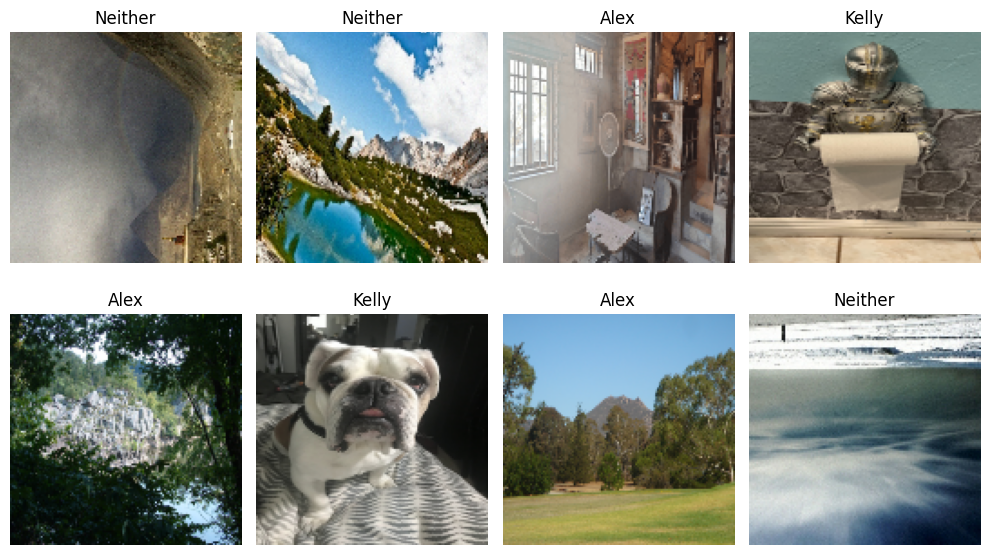

In [4]:
def visualize_batch(dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i].numpy())])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(train_ds, class_names=["Alex", "Kelly", "Neither"])

### Normalize and Optimize Datasets

To prepare our images for training, we normalize the pixel values using tf.keras.layers.Rescaling(1./255). This layer scales the original RGB values from the range [0, 255] down to [0, 1], which is a standard practice in deep learning. Normalization helps the model train more efficiently by stabilizing gradients, improving convergence, and ensuring that inputs are on a consistent scale, especially important when using activation functions like ReLU or Sigmoid.

In [5]:
# Normalize images to [0, 1] range
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: normalization_layer(x)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Approach 1

In [6]:
def train_feature_cnn(feature_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, epochs=20):
    train_path = os.path.join(feature_dir, "train")
    # Load unbatched dataset to extract class distribution
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=None,  # unbatched for label extraction
        validation_split=0.2,
        subset="training",
        seed=42,
        label_mode="binary"
    )

    # Extract labels to compute class weights
    label_list = [int(y.numpy()) for _, y in raw_train_ds]
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(label_list),
        y=label_list
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Load batched training and validation datasets
    train_ds = raw_train_ds.batch(batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        label_mode="binary"
    )

    # Data augmentation for training set
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    rescale = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (data_augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # CNN model
    model = models.Sequential([
        tf.keras.Input(shape=img_size + (3,)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train with class weights
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        class_weight=class_weights_dict
    )

    return model, history

### Human Detection

In [7]:
human_model, human_history = train_feature_cnn("Human_Pics", epochs=100)

Found 890 files belonging to 2 classes.
Using 712 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 890 files belonging to 2 classes.
Using 178 files for validation.
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4999 - loss: 0.7093 - val_accuracy: 0.3933 - val_loss: 0.7104
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5170 - loss: 0.6813 - val_accuracy: 0.6348 - val_loss: 0.6793
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6824 - loss: 0.6605 - val_accuracy: 0.6292 - val_loss: 0.6701
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6493 - loss: 0.6672 - val_accuracy: 0.6292 - val_loss: 0.6779
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6502 - loss: 0.6468 - val_accuracy: 0.6404 - val_loss: 0.6675
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7042 - loss: 0.6507 - val_accuracy: 0.5730 - val_loss: 0.7239
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7047 - loss: 0.5896 - val_accuracy: 0.6461 - val_loss: 0.6593
Epoch 8/100
23/23 ━━━━━━━━━━━━━

### Castle Detection

In [8]:
castle_model, castle_history = train_feature_cnn("Castle_Pics", epochs = 100)

Found 1424 files belonging to 2 classes.
Using 1140 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1424 files belonging to 2 classes.
Using 284 files for validation.
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.7395 - loss: 0.7292 - val_accuracy: 0.8662 - val_loss: 0.3001
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8373 - loss: 0.4061 - val_accuracy: 0.8697 - val_loss: 0.2880
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8421 - loss: 0.3882 - val_accuracy: 0.8732 - val_loss: 0.2967
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8600 - loss: 0.3367 - val_accuracy: 0.8521 - val_loss: 0.3254
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8838 - loss: 0.3067 - val_accuracy: 0.8803 - val_loss: 0.2917
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8888 - loss: 0.2558 - val_accuracy: 0.9014 - val_loss: 0.2686
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8880 - loss: 0.2810 - val_accuracy: 0.8944 - val_loss: 0.2481
Epoch 8/100
36/36 ━━━━━━━━━━━━

### Food Detection

In [9]:
# food_model, food_history = train_feature_cnn("Food_Pics")

### Indoor / Outdoor Detecttion

In [10]:
indoor_outdoor_model, indoor_outdoor_history = train_feature_cnn("Indoor_Outdoor_Pics")

Found 770 files belonging to 2 classes.
Using 616 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 770 files belonging to 2 classes.
Using 154 files for validation.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.5011 - loss: 0.7707 - val_accuracy: 0.6429 - val_loss: 0.6511
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6787 - loss: 0.6323 - val_accuracy: 0.7597 - val_loss: 0.4762
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7468 - loss: 0.5540 - val_accuracy: 0.7273 - val_loss: 0.5171
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7487 - loss: 0.5478 - val_accuracy: 0.8052 - val_loss: 0.4171
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7893 - loss: 0.5049 - val_accuracy: 0.8117 - val_loss: 0.4380
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8050 - loss: 0.4535 - val_accuracy: 0.7857 - val_loss: 0.4961
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8129 - loss: 0.4461 - val_accuracy: 0.8442 - val_loss: 0.3714
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 

### Pet Detection

In [11]:
pet_model, pet_history = train_feature_cnn("Pet_Pics")

Found 18728 files belonging to 2 classes.
Using 14983 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 18728 files belonging to 2 classes.
Using 3745 files for validation.
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 103ms/step - accuracy: 0.5565 - loss: 0.6974 - val_accuracy: 0.6550 - val_loss: 0.6164
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.6761 - loss: 0.6016 - val_accuracy: 0.7239 - val_loss: 0.5446
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7199 - loss: 0.5447 - val_accuracy: 0.7519 - val_loss: 0.5168
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.7631 - loss: 0.4883 - val_accuracy: 0.7744 - val_loss: 0.4895
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.7923 - loss: 0.4398 - val_accuracy: 0.7658 - val_loss: 0.5281
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.8191 - loss: 0.3992 - val_accuracy: 0.7701 - val_loss: 0.5491
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.8501 - loss: 0.3438 - val_accuracy: 0.7834 - val_loss: 0.5349
Epoch 8/20
469

### Vehicle Detection

In [12]:
vehicle_model, vehicle_history = train_feature_cnn("Vehicle_Pics")

Found 17730 files belonging to 2 classes.
Using 14184 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 17730 files belonging to 2 classes.
Using 3546 files for validation.
Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - accuracy: 0.8802 - loss: 0.2813 - val_accuracy: 0.9856 - val_loss: 0.0490
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9746 - loss: 0.0782 - val_accuracy: 0.9913 - val_loss: 0.0277
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.9821 - loss: 0.0630 - val_accuracy: 0.9884 - val_loss: 0.0359
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.9807 - loss: 0.0610 - val_accuracy: 0.9752 - val_loss: 0.0702
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.9824 - loss: 0.0544 - val_accuracy: 0.9851 - val_loss: 0.0431
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.9861 - loss: 0.0395 - val_accuracy: 0.9924 - val_loss: 0.0239
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.9892 - loss: 0.0319 - val_accuracy: 0.9927 - val_loss: 0.0256
Epoch 8/20
444/

### Flower Detection

In [36]:
flower_model, flower_history = train_feature_cnn("Flower_Pics")

Found 1367 files belonging to 2 classes.
Using 1094 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_7412\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1367 files belonging to 2 classes.
Using 273 files for validation.
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5197 - loss: 0.7547 - val_accuracy: 0.5751 - val_loss: 0.7889
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8088 - loss: 0.3966 - val_accuracy: 0.8388 - val_loss: 0.3287
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9322 - loss: 0.1973 - val_accuracy: 0.8425 - val_loss: 0.4287
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9126 - loss: 0.2258 - val_accuracy: 0.9231 - val_loss: 0.2022
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9507 - loss: 0.1389 - val_accuracy: 0.9194 - val_loss: 0.1870
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9504 - loss: 0.1367 - val_accuracy: 0.9304 - val_loss: 0.1646
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9505 - loss: 0.1296 - val_accuracy: 0.9231 - val_loss: 0.2040
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━

## Approach 2

To prevent overfitting and ensure generalization, we used early stopping with restore_best_weights=True. This allowed the model to automatically revert to the epoch that achieved the lowest validation loss. As a result, our final model reflects the best performance observed during training.

In [33]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
def train_alex_kelly_classifier_transfer(data_dir="Alex_Kelly_Pics/train", img_size=(128, 128), batch_size=32, epochs=30):
    # Step 1: Load raw dataset for class weight calculation (use int labels)
    raw_label_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    y_train_int = []
    for _, labels in raw_label_ds:
        y_train_int.extend(labels.numpy())
    y_train_int = np.array(y_train_int)

    class_weights = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_int),
        y=y_train_int
    )))

    # Step 2: Load datasets again for model training (same int labels)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    # Step 3: Normalize and augment
    rescale = layers.Rescaling(1./255)
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    train_ds = train_ds.map(lambda x, y: (augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # Step 4: Define transfer learning model
    base_model = applications.MobileNetV2(input_shape=img_size + (3,),
                                          include_top=False,
                                          weights="imagenet")
    base_model.trainable = False  # Freeze base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(3, activation='softmax')  # 3 classes: Alex, Kelly, Neither
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Step 5: Train with early stopping and class weights
    early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[early_stop])

    return model, history

In [34]:
model, history = train_alex_kelly_classifier_transfer()

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.3909 - loss: 2.8884 - val_accuracy: 0.5874 - val_loss: 2.0407
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6085 - loss: 1.9375 - val_accuracy: 0.7483 - val_loss: 1.7938
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7181 - loss: 1.7411 - val_accuracy: 0.7552 - val_loss: 1.6054
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7780 - loss: 1.5105 - val_accuracy: 0.7622 - val_loss: 1.4773
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8057 - loss: 1.3489 - val_accuracy: 0.7483 - val_loss: 1.4210
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7876 - loss: 1.2734 - val_accuracy: 0.7552 - val_loss: 1.2917
Epoch 7/30
18/18 ━━━

In [31]:
from tensorflow.keras.preprocessing import image
def predict_and_visualize_thresholded(model, test_dir, class_names, img_size=(128, 128), threshold=0.6, max_images=20):
    image_files = sorted([
        f for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:max_images]

    plt.figure(figsize=(15, 8))

    for i, fname in enumerate(image_files):
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        predicted_idx = np.argmax(prediction)
        confidence = prediction[predicted_idx]

        if confidence < threshold:
            predicted_label = "Neither"
        else:
            predicted_label = class_names[predicted_idx]

        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label}\n({confidence:.2f})", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

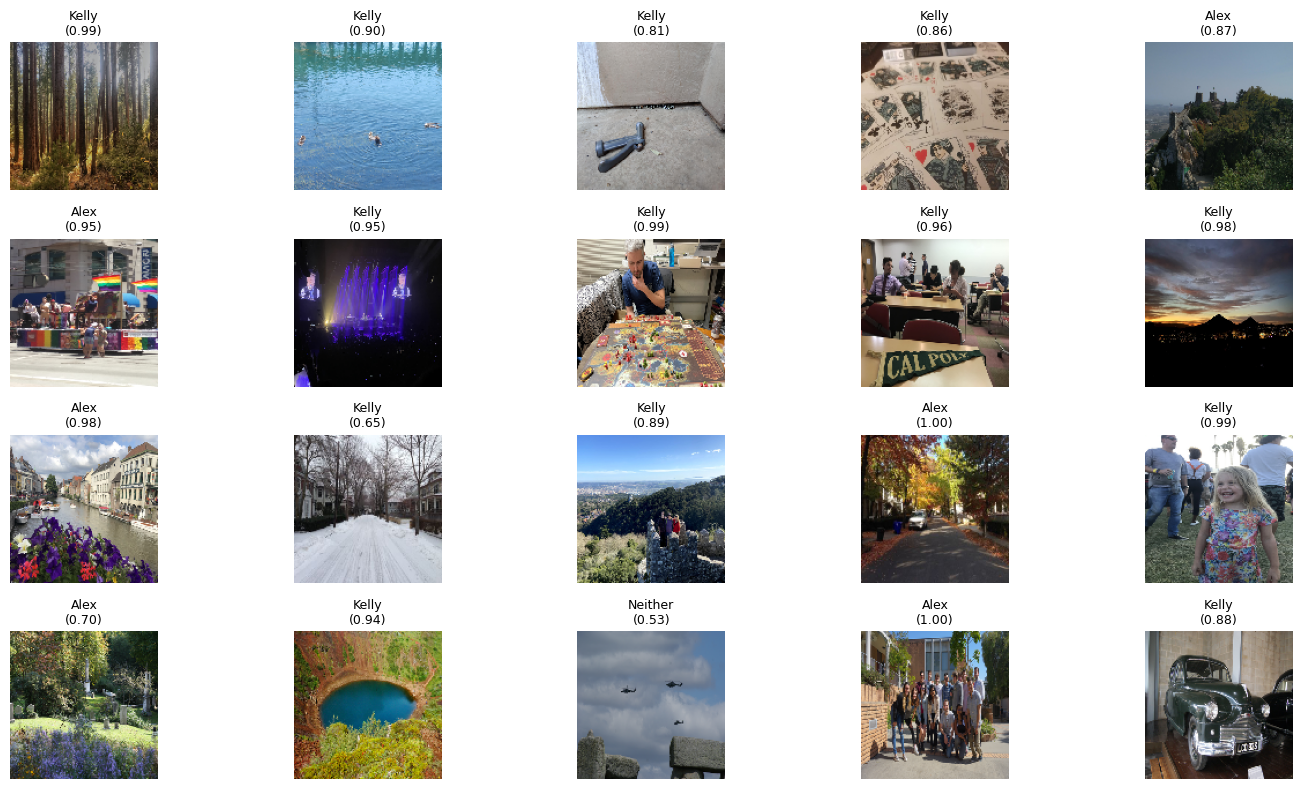

In [32]:
test_dir = "Alex_Kelly_Pics/test/TestSet"
class_names = ["Alex", "Kelly", "Neither"]
predict_and_visualize_thresholded(model, test_dir, class_names)